<a href="https://colab.research.google.com/github/ruas-pedro/analisem_ols_ipca_R/blob/main/Prevendo_o_PIB_com_IA_workshop05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workshop "Como Prever o PIB do Brasil com IA e Python?"**
---

O Produto Interno Bruto (PIB) é a soma de todos os bens e serviços finais produzidos por um país, estado ou cidade, em um determinado período no tempo.

É um indicador que ajuda a compreender a dinâmica de crescimento da economia como um todo, constituindo uma variável macroeconômica relevante para o governo, para a política monetária e para a população de forma geral.


Pela complexidade de cômputo e pela sensibilidade a crises e choques adversos, é razoável pensar que produzir previsões para o PIB é uma tarefa difícil e não muito glamourosa para profissionais que trabalham com previsão.


Pensando nisso, decidimos organizar um Workshop sobre Como Prever o PIB do Brasil utilizando os novos recursos da Inteligência Artificial. Em três horas, faremos uma exposição mão na massa e direta ao ponto, utilizando Python, para que o aluno consiga entender diversos nuances do difícil trabalho de gerar previsões acuradas para uma variável econômica tão importante quanto o PIB do país.


# **Parte 01: Bibliotecas**
---
Aqui vamos importar bibliotecas de Python que ajudam com funções úteis e prontas para coletar, tratar e analisar dados.

In [ ]:
# Instalar bibliotecas
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.7 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas
import pandas as pd
import pmdarima as pmd
import google.generativeai as genai
from google.colab import userdata
from io import StringIO

# **Parte 02: Coleta de Dados**
---

Aqui vamos escrever um código que acessa uma fonte de dados e baixa uma tabela automaticamente.


Assign() funciona como o mutate no R. Assim ele vai modificar e criar colunas. Nesse caso, informamos o nome da coluna "date" a ser modificada (ou criada), escrevemos lambda x, para indicar que criaremos uma função a seguir, e depois escrevemos o que será feito nessa coluna.

Nesse caso a função pd.PeriodIndex modifica a coluna date do objeto x, x.date (x representa o objeto "dado") transformando as datas para uma frequência de quadrimestre  Q (freq = Q).

A função set_index define a coluna date como index

In [ ]:
# Importar os dados
dados = pd.read_csv(
    filepath_or_buffer = "https://drive.google.com/uc?export=download&id=1ctQEVOsrjWWc-7_Us6GPacFC6bQe8G79"
    ).assign(date = lambda x: pd.PeriodIndex(x.date, freq = "Q")).set_index("date")
dados

,PIB
date,
1996Q1,2.5
1996Q2,2.1
1996Q3,2.3
1996Q4,2.2
1997Q1,3.2
...,...
2023Q1,3.7
2023Q2,3.7
2023Q3,3.1


fiz isso só para baixar os dados


In [ ]:
dados.to_csv('dados.csv', index=True)

# **Parte 03: Modelagem e Previsão**
---

Aqui vamos escrever um código para estimar um modelo automatizado de econometria e um modelo de inteligência artificial e gerar previsão para um período de teste.

In [ ]:
# Separa parte dos dados para teste de previsão
h = 4
dados_teste = dados.tail(h) # tail(4) indica que são as 4 últimas obs
dados_treino = dados.iloc[0:-h]  # esse iloc indica que vai da observação zero a até a anterior as últimas 4

## Modelo de econometria

Essa função "pmd.auto_arima" roda um arima de forma automatizada, necessitando apenas que vc de os dados a ela, não precisa fazer especificações. Isso tem vantagens e desvantagens


In [ ]:
# Estimar o modelo automatizado ARIMA
modelo_arima = pmd.auto_arima(y = dados_treino.PIB, m = h) # y são os dados (nome do objeto.nome da coluna)
                                                           # m = 4 indica a divisão trimestral(Q). 1 seria anual
modelo_arima

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 4),
      suppress_warnings=True)

Em cima ele retornou o tipo de modelo que ele produziu, pelo que entendi um AR2. Porém, para fazer a previsão é preciso botar a função .predict() indicando o número de previsões a frente, nesse caso será 4.
então o modelo ficará assim

modelo_arima = pmd.auto_arima(y = dados_treino.PIB, m = 4).predict(4)


In [ ]:
# Produzir previsão
previsao_arima = modelo_arima.predict(h).rename("ARIMA").to_frame() # rename nomeia a série como "arima" e to_frame transforma ela em um dataframe
previsao_arima

,ARIMA
2023Q2,3.547208
2023Q3,2.949304
2023Q4,2.589961
2024Q1,2.026677


In [ ]:
print(modelo_arima.summary()) #para ver as especificações do modelo basta por .summary() no final.
                              # A função print apenas deixa a visibilidade melhor

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  109
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 4)   Log Likelihood                -103.272
Date:                           Wed, 18 Dec 2024   AIC                            218.544
Time:                                   15:54:58   BIC                            234.692
Sample:                               03-31-1996   HQIC                           225.093
                                    - 03-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1828      0.099      1.840      0.066      -0.012       0.378
ar.L1          1.6777      0.070     24.024

## Modelo de inteligência artificial

Para prever o PIB com inteligência artificial usamos o google ia studio(https://aistudio.google.com). Aqui o que será feito é o uso desse artifício direto pelo google colab. Para isso

In [ ]:
# Salva dados como um arquivo CSV para enviar para a IA do google
dados_treino.to_csv("historical_pib.csv")

In [ ]:
# Configura chave de token (acesse https://ai.google.dev/gemini-api/docs/api-key
# para obter uma chave)
genai.configure(api_key = userdata.get("GEMINI_API_KEY")) # Esse "GEMINI_API_KEY" não é a chave em si
                                                          # é um objeto criado ali no símbolo de chave (secret)
                                                          # para que a chave real fique secreta


In [ ]:
# Envia arquivo CSV para API do Google (lembrar que tem que salvar esse resultado em um objeto)
arquivo = genai.upload_file("historical_pib.csv")

In [ ]:
# Define prompt
data_previsao = (dados_treino.index.max() + 1).strftime("%B 30, %Y")
periodo_previsao = dados_teste.index[[0, h - 1]].strftime("%YQ%q").to_list()

prompt = f"""
Assume that you are in {data_previsao}.
Please give me your best forecast of Gross Domestic Product (GDP) for Brazil,
measured in annual percentage variation (accumulated rate in four quarters in
relation to the same period of the previous year) and published by IBGE, for
{periodo_previsao[0]} to {periodo_previsao[1]}.
Use the historical GDP data from the attached CSV file named "historical_pib.csv",
where "pib" is the target column and "date" is the date column.
Please give me numeric values for these forecasts, in a CSV like format, and
nothing more.
Do not use any information that was not available to you as of {data_previsao}
to formulate these forecasts.
"""
print(prompt)


Assume that you are in June 30, 2023.
Please give me your best forecast of Gross Domestic Product (GDP) for Brazil,
measured in annual percentage variation (accumulated rate in four quarters in
relation to the same period of the previous year) and published by IBGE, for
2023Q2 to 2024Q1.
Use the historical GDP data from the attached CSV file named "historical_pib.csv",
where "pib" is the target column and "date" is the date column.
Please give me numeric values for these forecasts, in a CSV like format, and
nothing more.
Do not use any information that was not available to you as of June 30, 2023
to formulate these forecasts.



In [ ]:
# Define modelo LLM e envia prompt
modelo_ia = genai.GenerativeModel(model_name = "gemini-1.5-pro", generation_config = {"temperature": 0.1})
resposta_ia = modelo_ia.generate_content([prompt, arquivo]) #arquivo são os dados de treino sendo enviados para a ia

# Imprime resposta do modelo
print(resposta_ia.text)

date,PIB
2023Q2,3.2
2023Q3,2.8
2023Q4,2.3
2024Q1,1.8



In [ ]:
# Converte texto para tabela
previsao_ia = pd.read_csv(
    filepath_or_buffer = StringIO(resposta_ia.text), #stringIO é pq esse dado está dentro do próprio python,
                                                     #essa função faz serve para ler uma string como um arquivo
    names = ["date", "Gemini"],
    skiprows = 1 #isso aqui é para desconsiderar a primeira linha, qua no caso são os títulos das colunas
    ).assign(date = lambda x: pd.PeriodIndex(x.date, freq = "Q")).set_index("date") #botou a coluna como trimestral e index (antes ela não estava sendo lida como data)
previsao_ia

,Gemini
date,
2023Q2,3.2
2023Q3,2.8
2023Q4,2.5
2024Q1,2.2


# Unindo Tabelas

In [ ]:
previsao1 = dados.join([previsao_arima, previsao_ia]) #aqui eu uni os dados do objeto dados
                                                    # com os dos objetos previsao_arima e previsao_ia

previsao1

,PIB,ARIMA,Gemini
date,,,
1996Q1,2.5,NaN,NaN
1996Q2,2.1,NaN,NaN
1996Q3,2.3,NaN,NaN
1996Q4,2.2,NaN,NaN
1997Q1,3.2,NaN,NaN
...,...,...,...
2023Q1,3.7,NaN,NaN
2023Q2,3.7,3.547208,3.2
2023Q3,3.1,2.949304,2.8


# Gráfico de previsão

Agora pego os dados do pib e das previsões e monto um gráfico com isso usando a função .plot()

<Axes: xlabel='date'>

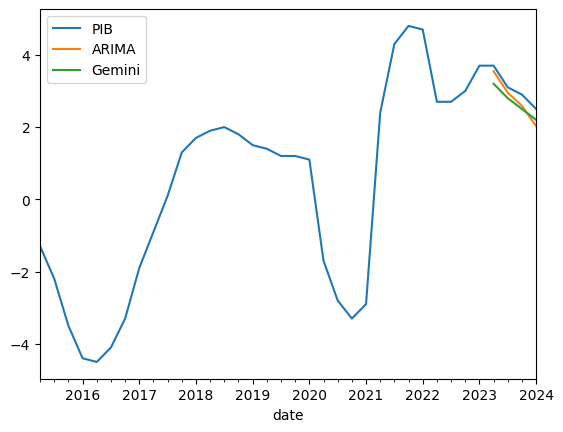

In [ ]:
previsao1.tail(36).plot()

## Avaliação de erros

Agora farei a mesma coisa porém considerando apenas as 40 últimas observações

In [ ]:
# Junta dados observados e de previsão
tabela_previsao = (
    dados
    .tail(h*10)
    .join(other = [previsao_arima, previsao_ia], how = "outer") # "other" informa quais dados serão inidos e "outher"
    .assign(Ensemble = lambda x: (x.ARIMA + x.Gemini) / 2) #cria uma coluna chamada ensemble a partir da média entre as colunas "ARIMA" e "GEMINI"
)
tabela_previsao.tail(h)

,PIB,ARIMA,Gemini,Ensemble
2023Q2,3.7,3.547208,3.2,3.373604
2023Q3,3.1,2.949304,2.8,2.874652
2023Q4,2.9,2.589961,2.5,2.544981
2024Q1,2.5,2.026677,2.2,2.113338


# Gráfico

Novamente usamos a função .plot(), porém agora com mais especificações. Essa função é do pacote pandas, mas mais especificamente do matplotly que tbm está dentro do pandas. Agora temos aprevisão da coluna esemble que é a média das outras duas.

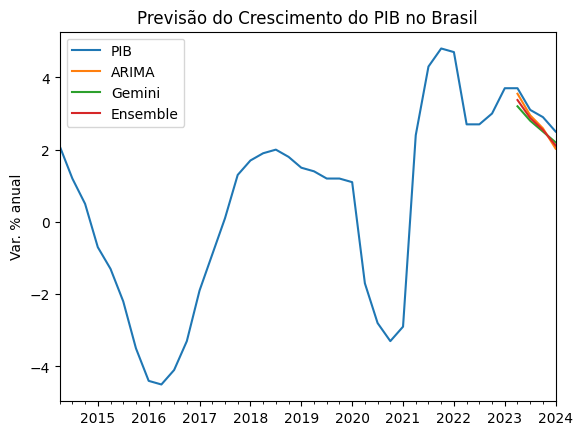

In [ ]:
# Avalia erro visualmente
tabela_previsao.plot(
    title = "Previsão do Crescimento do PIB no Brasil",
    xlabel = "",
    ylabel = "Var. % anual"
    );

In [ ]:
# Avalia erro numéricamente
erros_previsao = (
    tabela_previsao
    .dropna()
    .assign(
        erro_arima = lambda x: x.PIB - x.ARIMA,
        erro_gemini = lambda x: x.PIB - x.Gemini,
        erro_ensemble = lambda x: x.PIB - x.Ensemble
    )
)
erros_previsao

,PIB,ARIMA,Gemini,Ensemble,erro_arima,erro_gemini,erro_ensemble
2023Q2,3.7,3.547208,3.5,3.523604,0.152792,0.2,0.176396
2023Q3,3.1,2.949304,3.3,3.124652,0.150696,-0.2,-0.024652
2023Q4,2.9,2.589961,3.1,2.844981,0.310039,-0.2,0.055019
2024Q1,2.5,2.026677,3.0,2.513338,0.473323,-0.5,-0.013338


In [ ]:
# Calcula métricas de erro
print(f"Erro médio do ARIMA é: {erros_previsao.erro_arima.mean().round(3)}")
print(f"Erro médio do Gemini é: {erros_previsao.erro_gemini.mean().round(3)}")
print(f"Erro médio do Ensemble é: {erros_previsao.erro_ensemble.mean().round(3)}")

Erro médio do ARIMA é: 0.272
Erro médio do Gemini é: -0.175
Erro médio do Ensemble é: 0.048
